# GAMALOS (GAlaxies MAking LOve Simulation)

## Theoric remarks

Report: write a short report containing:
- a short introduction to the N-body problem, the difference between
collisional and collisionless systems and the force estimate in
collisionless simulations based on tree algorithms. Short general
description of the fireworks package and its implementation.
- Description of the methods (integrators, force estimator) used.
- Description of the initial conditions and simulation setup.
- Results and discussion. They depends on the specific project you
chose, but I expect at least one plot showing the main conclusion of
your analysis.

<div class='alert alert-danger' role='alert'>
Inserisci info teoriche
</div>

## Computation

In [1]:
#first of all, we import all the packages for Particles, integrators, ic...

import numpy as np
import pandas as pd
from fireworks.ic import ic_two_body
import matplotlib.pyplot as plt
from fireworks.nbodylib.integrators import integrator_leapfrog_galaxy, integrator_leapfrog, integrator_leapfrog_galaxy_encounter, integrator_tsunami
from fireworks.nbodylib.dynamics import acceleration_pyfalcon
from fireworks.nbodylib.timesteps import adaptive_timestep_r
from fireworks.particles import Particles
from typing import Optional, Tuple, Callable, Union
import time

#from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget

We can import the data of one galaxy at first. The units are still Nbody units.

In [2]:
df_0 = pd.read_csv("data_cvs/Nbody_disc.csv")

# slice dataframe
num_particles = 1e3
df = df_0.iloc[:int(num_particles)]

df.head(10)

,mass,x,y,z,vx,vy,vz
0,1.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1,1.000000e-11,-3.419583,-1.901788,0.0,0.118878,-0.213752,0.0
2,1.000000e-11,-14.046839,-2.403541,0.0,0.040952,-0.239330,0.0
3,1.000000e-11,-4.618003,6.269821,0.0,-0.222721,-0.164044,0.0
4,1.000000e-11,-6.045516,0.257974,0.0,-0.011730,-0.274897,0.0
5,1.000000e-11,-1.393104,1.578234,0.0,-0.124900,-0.110249,0.0
6,1.000000e-11,-1.150877,-1.762433,0.0,0.139480,-0.091081,0.0
7,1.000000e-11,0.593887,-1.003781,0.0,0.086283,0.051049,0.0
8,1.000000e-11,2.423492,-10.266498,0.0,0.257402,0.060762,0.0
9,1.000000e-11,-3.279328,5.118040,0.0,-0.231783,-0.148512,0.0


### 1. Initial conditions
We generated a Particles instance for each galaxy

In [3]:
# create a class with the mass, pos, vel of each element of the Galaxy

masses = df[['mass']]
positions = df[['x', 'y', 'z']]
velocities = df[['vx', 'vy', 'vz']]

# reshape mass array as 1D array
masses = masses.values.reshape(-1)

Galaxy1 = Particles(positions.values, velocities.values, masses)
print(Galaxy1.pos.shape)

(1000, 3)


In [4]:
# do the same for the other galaxy
# this second galaxy is the same as the first one, but translated by a certain value

pos_translation = np.array((40., 20., 0.))
vel_translation = np.array((-0.2, 0., 0.))

# apply this translation to find the second galaxy

positions_gal_2 = positions.values + pos_translation
velocities_gal_2 = velocities.values + vel_translation
Galaxy2 = Particles(positions_gal_2, velocities_gal_2, masses)

### Rotation curve and Surface density profile
Let's plot the rotation curve and the surface density profile for one galaxy, in particular for Galaxy 1. 

The **rotation curve** of a galaxy shows the azimuthal velocity as function of the cylindrical radius . To estimate the azimuthal velocity for each particle we transform the Cartesian coordinates to cylindrical: 

$$
\begin{cases}
R_{\text{cyl}} = \sqrt(x^2+y^2) \\
\phi = \arctan(\frac{y}{x}) \\
z=z
\end{cases}
$$

We then computed the azymuthal velocity for all the particles using: 
$$
V_\phi = V_y \cdot \cos(\phi) - V_x\cdot \sin(\phi)
$$

We then plotted $V_\phi$ vs $R$ to obtain the rotation curve of the galaxy. 

The **surface density profile** $\Sigma$ shows the amount of mass in a cylindrical ring divided by the area of the ring. To estimate it we bin the particles on the cylindrical radius $R_{\text{cyl}}$, then we sum all the masses of the particles to obtain $M_{\text{tot, ring}}$ and then the area of the ring is given by $\pi (R^2_{\text{outer}}-R^2_{\text{inner}})$ where $R_{\text{inner}}$ and $R_{\text{outer}}$ are the borders of the considered bin. Finally $\Sigma_{\text{ring}}=M_{\text{tot, ring}}/A_{\text{ring}}$. 

We plotted the initial number suface density of the disc, which means that we use the number of particles instead of the total mass of the ring, as function of the cylindrical radius. 

In [23]:
def rotation_curve(x, y, z, vx, vy):
    # convert to cylindrical coordinates
    Rcyl = np.sqrt(x*x + y*y)                   # cylindrical radius
    phi = np.arctan2(y, x)                            # azimuthal angle
    z = z                                             # z-coordinate

    # compute azimuthal velocity    
    vel_phi = vy * np.cos(phi) - vx * np.sin(phi)     # azimuthal velocity

    return Rcyl, vel_phi

def surface_density(Rcyl):
    H, edge = np.histogram(Rcyl, bins=20)                                          # histogram of the cylindrical radius
    area =  np.pi * (edge[1:]**2 - edge[0:-1]**2)                                  # area of every bin (every concentric ring) 
    mid = 0.5 * (edge[1:] + edge[0:-1])                                            # midpoint of every bin  

    return mid, H, area

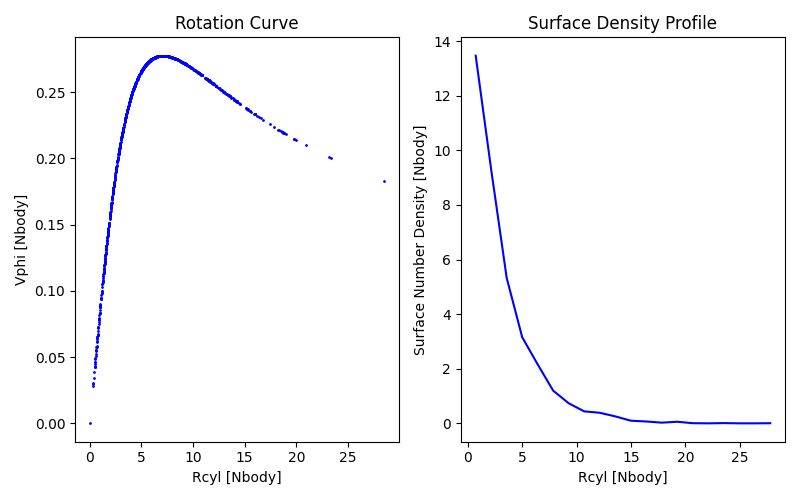

In [24]:
# compute rotation curve and surface density
Rcyl, vel_phi = rotation_curve(Galaxy1.pos[:, 0], Galaxy1.pos[:, 1], Galaxy1.pos[:, 2], Galaxy1.vel[:, 0], Galaxy1.vel[:, 1])
mid, H, area = surface_density(Rcyl)

# rotation curve plot
plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.plot(Rcyl, vel_phi, 'o', markersize=1, c='b')
plt.xlabel("Rcyl [Nbody]")
plt.ylabel("Vphi [Nbody]")
plt.title("Rotation Curve")

# surface density plot
plt.subplot(1, 2, 2)
#plt.yscale('log')
plt.plot(mid, H / area, c='b')
plt.xlabel("Rcyl [Nbody]")
plt.ylabel("Surface Number Density [Nbody]")
plt.title("Surface Density Profile")

plt.tight_layout()
plt.show()  


### Initial configuration of the galaxies

Text(0.5, 1.0, 'Galaxies 1 and 2 - intial positions')

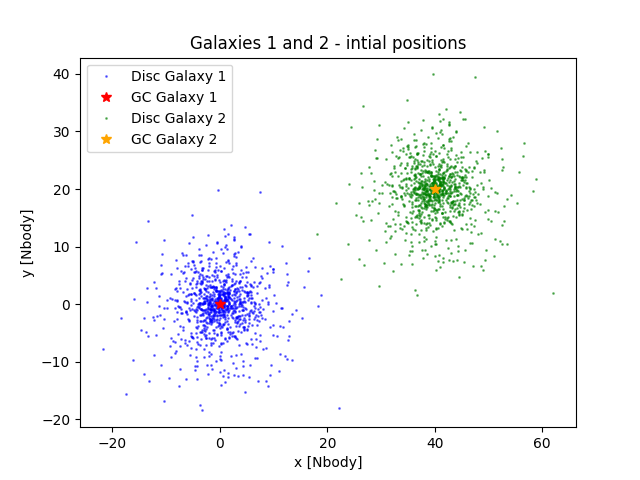

In [7]:
plt.figure()
plt.plot(Galaxy1.pos[1:,0], Galaxy1.pos[1:,1], 'o', markersize=1, c='b', label='Disc Galaxy 1', alpha=0.5)
plt.plot(Galaxy1.pos[0,0], Galaxy1.pos[0,1], '*', markersize=7, c='r', label='GC Galaxy 1')

plt.plot(Galaxy2.pos[1:,0], Galaxy2.pos[1:,1], 'o', markersize=1, c='g', label='Disc Galaxy 2', alpha=0.5)
plt.plot(Galaxy2.pos[0,0], Galaxy2.pos[0,1], '*', markersize=7, c='orange', label='GC Galaxy 2') 
plt.legend()

plt.xlabel('x [Nbody]')
plt.ylabel('y [Nbody]')
plt.title('Galaxies 1 and 2 - intial positions')

### Orbital integration of Galaxy 1
Let's try an orbital simulation of the first galaxy to see if the integration works (in this test we used the leap-frog method).

<div class = 'alert alert-block alert-warning'>
integrato con N=1e2 per velocizzare i vari test
</div>

Define helper function for the integration using `integrator_leapfrog_galaxy` and the method `Etot_vett` inside the Particles class.

In [55]:
def integration_leapfrog_adaptive(galaxy: Particles, h: float, tsimulation: float, t: float, soft: float):
    N = len(galaxy.mass)         # number of particles in the galaxy
    path = [galaxy.pos]          # list to store the position of the galaxy
    velocity = [galaxy.vel]      # list to store the velocity of the galaxy
    time = [t]
    timestep = [h]
    R_cyl = []
    V_phi = []

    ''' perchè marco aveva messo gia galaxy.pos e vel dentro le liste path e velocity? '''

    galaxy.pos -= galaxy.pos[0]  # move the galaxy to the center of mass
    galaxy.vel -= galaxy.vel[0]

    ''' rescale fuori o dentro il while? '''
    
    Etot_leapfrog = []
    Ekin_leapfrog = []
    Epot_leapfrog = []

    while t < tsimulation:
        result = integrator_leapfrog(particles=galaxy, tstep=h, acceleration_estimator=acceleration_pyfalcon, softening=soft)
        updated_galaxy, _,  updated_acc, _, _ = result
        path.append(updated_galaxy.pos)
        velocity.append(updated_galaxy.vel)
            
        Etot_n, Ekin_n, Epot_n = updated_galaxy.Etot_vett()
        Etot_leapfrog.append(Etot_n)
        Ekin_leapfrog.append(Ekin_n)
        Epot_leapfrog.append(Epot_n)
        
        #ts_1, _, _ = adaptive_timestep_r(galaxy)
        #h = ts_1
        timestep.append(h)
        t += h
        time.append(t)

        Rcyl, Vphi = rotation_curve(updated_galaxy.pos[:, 0], updated_galaxy.pos[:, 1], updated_galaxy.pos[:, 2], updated_galaxy.vel[:, 0], updated_galaxy.vel[:, 1])
        R_cyl.append(Rcyl)
        V_phi.append(Vphi) 


    path = np.array(path)
    velocity = np.array(velocity)
    time   = np.array(time)
    timestep  = np.array(timestep)
    R_cyl = np.array(R_cyl)
    V_phi = np.array(V_phi)

    Etot_leapfrog = np.array(Etot_leapfrog)
    Ekin_leapfrog = np.array(Ekin_leapfrog)
    Epot_leapfrog = np.array(Epot_leapfrog)

    return path, velocity, Etot_leapfrog, time, timestep, R_cyl, V_phi
                                                                                          

In [56]:
# compute the orbital period with T = 2*pi*sqrt(a^3/GM)

G = 1.                                                                   # gravitational constant in n-body units
plummer_scale_lenght = 5.                                                # scale lenght of the plummer sphere (softening)

central_mass = Galaxy1.mass[0]                                           # central mass of the galaxy

T = 2 * np.pi * np.sqrt(Galaxy1.radius()**3 / (G * central_mass))        # period of the galaxy using radius array  
T = np.mean(T)                                                           # mean period of the galaxy

print(f'Period of the galaxy (approximately): {T}')

# define the time of simulation and the number of steps

t0 = 0.                         # initial time
tsimulation = 1*T               # time of simulation (one period)
N = int(1e2)                    # number of steps
h = (tsimulation - t0)/N        # time steps

Period of the galaxy (approximately): 104.8239304318399


In [57]:
Galaxy1_test = Galaxy1.copy()

Galaxy1_orbit, Galaxy1_stars_vel, Galaxy1_Etot, Galaxy1_time, Galaxy1_timestep, Galaxy1_Rcyl, Galaxy1_Vphi = integration_leapfrog_adaptive(galaxy=Galaxy1_test, h=h, 
                                                                                            tsimulation=tsimulation, t=t0, soft=plummer_scale_lenght)

/root/miniconda3/lib/python3.10/site-packages/fireworks-0.0.5-py3.10.egg/fireworks/particles.py:275: RuntimeWarning: divide by zero encountered in divide


In [58]:
print(Galaxy1_orbit.shape)
# (iterations, particles, coordinates)

(101, 1000, 3)


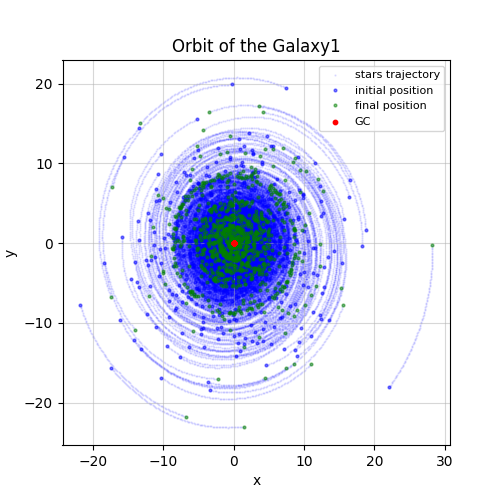

In [59]:
plt.figure(figsize=(5,5))
plt.scatter(Galaxy1_orbit[:,1:,0], Galaxy1_orbit[:,1:,1], s=0.5, color='b', label='stars trajectory', alpha=0.1)
plt.plot(Galaxy1_orbit[0,1:,0], Galaxy1_orbit[0,1:,1], 'o', markersize=2, c='b', label='initial position', alpha=0.5)
plt.plot(Galaxy1_orbit[-1,1:,0], Galaxy1_orbit[-1,1:,1], 'o', markersize=2, c='g', label='final position', alpha=0.5)
plt.scatter(Galaxy1_orbit[:,0,0], Galaxy1_orbit[:,0,1], s=10, color='r', label='GC', zorder=10)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Orbit of the Galaxy1')
plt.legend(loc='upper right', fontsize=8)
plt.grid(True, alpha=0.5)
plt.show()

We check the total energy error of our simulation. We define a general function we can use for all the simulations. 

In [60]:
def total_energy_error(Etot, initial_t, tsimulation, h):
    energy_error = np.zeros(len(Etot))

    for i in range(len(Etot)):
        energy_error[i] = np.abs((Etot[i] - Etot[0])/Etot[0])

    time = np.arange(0, tsimulation, h)

    return energy_error, time

/tmp/ipykernel_56028/2179581832.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(5,5))


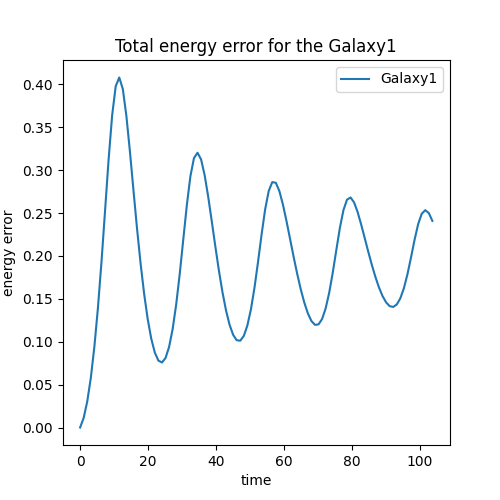

In [61]:
# calculate the error of the total energy for Galaxy1

energy_error, time = total_energy_error(Etot=Galaxy1_Etot, initial_t=t0, tsimulation=tsimulation, h=h)


# plot the error of the total energy for Galaxy1
plt.figure(figsize=(5,5))
plt.plot(time, energy_error, label='Galaxy1')
plt.xlabel('time')
plt.ylabel('energy error')
plt.title('Total energy error for the Galaxy1')
plt.legend()
plt.show()


<div class='alert alert-block alert-warning'>
mi pare tanto grande l'errore o sbaglio? penso sia dovuto al fatto degli ordini di grandezza che diceva mattia but not sure
</div>

### Stability of the rotation curve

In [50]:
# intiial rotation curve
Rcyl, vel_phi = rotation_curve(Galaxy1.pos[:, 0], Galaxy1.pos[:, 1], 
                               Galaxy1.pos[:, 2], Galaxy1.vel[:, 0], Galaxy1.vel[:, 1])

# rotation curve after the simulation
fin = -1
Rcyl_end, vel_phi_end = rotation_curve(Galaxy1_orbit[fin,:,0], Galaxy1_orbit[fin,:,1],
                                        Galaxy1_orbit[fin,:,2] - Galaxy1_orbit[fin,0,2], Galaxy1_stars_vel[fin,:,0] - Galaxy1_stars_vel[fin,0,0], 
                                        Galaxy1_stars_vel[fin,:,1] - Galaxy1_stars_vel[fin,0,1])

# snapshot of the rotation curve
snap = len(Galaxy1_orbit[:,0,0])//2
Rcyl_mid, vel_phi_mid = rotation_curve(Galaxy1_orbit[snap,:,0], Galaxy1_orbit[snap,:,1],
                                        Galaxy1_orbit[snap,:,2], Galaxy1_stars_vel[snap,:,0], Galaxy1_stars_vel[snap,:,1])


In [63]:
print(Galaxy1_Rcyl.shape)

(100, 1000)


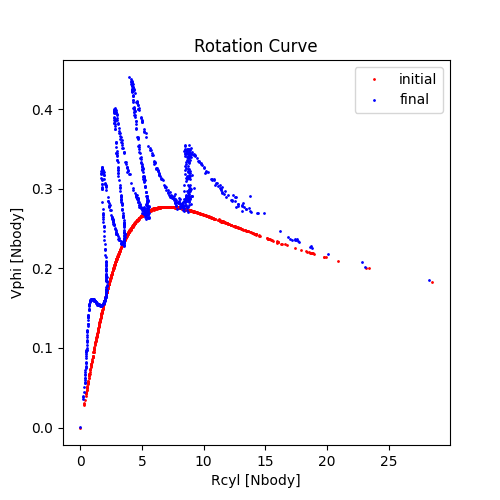

In [64]:
plt.figure(figsize=(5,5))
plt.plot(Galaxy1_Rcyl[0,:], Galaxy1_Vphi[0,:], 'o', markersize=1, c='r', label='initial')
#plt.plot(Rcyl_mid, vel_phi_mid, 'o', markersize=1, c='g', label='mid')
plt.plot(Galaxy1_Rcyl[-1,:], Galaxy1_Vphi[-1,:], 'o', markersize=1, c='b', label='final')
plt.xlabel("Rcyl [Nbody]")
plt.ylabel("Vphi [Nbody]")
plt.title("Rotation Curve")
plt.legend()
plt.show()


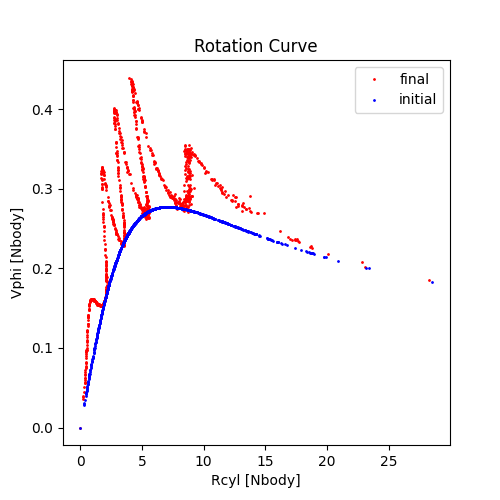

In [51]:
plt.figure(figsize=(5,5))
plt.plot(Rcyl_end, vel_phi_end, 'o', markersize=1, c='r', label='final')
#plt.plot(Rcyl_mid, vel_phi_mid, 'o', markersize=1, c='g', label='mid')
plt.plot(Rcyl, vel_phi, 'o', markersize=1, c='b', label='initial')
plt.xlabel("Rcyl [Nbody]")
plt.ylabel("Vphi [Nbody]")
plt.title("Rotation Curve")
plt.legend()
plt.show()


<div class='alert alert-block alert-warning'>
boh qua non capisco sempre solito problema io ci rinuncio
</div>

In [ ]:
# intial surface density
mid, H, area = surface_density(Rcyl)

# final surface density
mid_end, H_end, area_end = surface_density(Rcyl_end)

# snapshot of the surface density
mid_mid, H_mid, area_mid = surface_density(Rcyl_mid)

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(mid, H / area, c='b', label='initial')
plt.plot(mid_mid, H_mid / area_mid, c='g', label='mid')
plt.plot(mid_end, H_end / area_end, c='r', label='final')
plt.yscale('log')
plt.xlabel("Rcyl [Nbody]")  
plt.ylabel("Surface Number Density [Nbody]")
plt.title("Surface Density Profile")
plt.legend()
plt.show()

### Galaxy encounter

We run a galaxy encounter and then we show how the velocity curve and the disc surface profile evolve with time. 

In [ ]:
def integration_leapfrog_encounter(galaxy1: Particles, galaxy2: Particles, h: float, tsimulation: float, t: float, soft: float):
    path1 = [galaxy1.pos]
    path2 = [galaxy2.pos]
    velocity1 = [galaxy1.vel]
    velocity2 = [galaxy2.vel]
    time = [t]
    timestep = [h]
    
    Etot_leapfrog = []
    Ekin_leapfrog = []
    Epot_leapfrog = []

    while t < tsimulation:
        result1, result2 = integrator_leapfrog_galaxy_encounter(particles1=galaxy1, particles2=galaxy2, tstep=h, acceleration_estimator=acceleration_pyfalcon, softening=soft)
        updated_galaxy1, _, _, _ = result1
        updated_galaxy2, _, _, _ = result2
        updated_galaxy2.pos -= updated_galaxy2.pos[0]
        updated_galaxy2.vel -= updated_galaxy2.vel[0]
        path1.append(updated_galaxy1.pos)
        path2.append(updated_galaxy2.pos)
        velocity1.append(updated_galaxy1.vel)
        velocity2.append(updated_galaxy2.vel)
            
        Etot_n1, Ekin_n1, Epot_n1 = updated_galaxy1.Etot_vett()
        Etot_n2, Ekin_n2, Epot_n2 = updated_galaxy2.Etot_vett()
        Etot_leapfrog.append(Etot_n1 + Etot_n2)
        Ekin_leapfrog.append(Ekin_n1 + Ekin_n2)
        Epot_leapfrog.append(Epot_n1 + Epot_n2)
        
        timestep.append(h)
        t += h
        time.append(t)

    path1 = np.array(path1)
    path2 = np.array(path2)
    velocity1 = np.array(velocity1)
    velocity2 = np.array(velocity2)
    time   = np.array(time)
    timestep  = np.array(timestep)

    Etot_leapfrog = np.array(Etot_leapfrog)
    Ekin_leapfrog = np.array(Ekin_leapfrog)
    Epot_leapfrog = np.array(Epot_leapfrog)

    return path1, path2, velocity1, velocity2 #, time, timestep, Etot_leapfrog, Ekin_leapfrog, Epot_leapfrog

In [ ]:

def plot_galaxies(galaxy1_orbit, galaxy2_orbit):
    plt.figure()

    # Plot the positions of the particles in each galaxy
    plt.scatter(galaxy1_orbit[:, :, 0], galaxy1_orbit[:, :, 1], s=5, label='Galaxy 1', alpha=0.2)
    plt.scatter(galaxy2_orbit[:, :, 0], galaxy2_orbit[:, :, 1], s=1, label='Galaxy 2', alpha=0.2)

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Galaxy Encounter')
    plt.legend()
    plt.show()


In [ ]:
# Run the encounter simulation
galaxy1 = Galaxy1.copy()
galaxy2 = Galaxy2.copy()

softening = 5
t0 = 0.                         # initial time
tsimulation = 210               # time of simulation (one period)
N = int(1e2)                    # number of steps
h = (tsimulation - t0)/N        # time steps

galaxy1_orbit, galaxy2_orbit, galaxy1_vel, galaxy2_vel = integration_leapfrog_encounter(galaxy1, galaxy2, h, tsimulation, t0, softening)

# Plot the final positions
plot_galaxies(galaxy1_orbit, galaxy2_orbit)